<a href="https://colab.research.google.com/github/suchanek/PMA/blob/master/ImgStuff2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set up Drive and Colab
from google.colab import drive 
drive.mount('/content/drive')

NotebookDir = "/content/drive/My Drive/Colab Notebooks/"
ModuleDir = "/content/drive/My Drive/Colab Notebooks/bby"

DataDir = "/content/drive/My Drive/data/"
ArtDir = "/content/drive/My Drive/art_egs/"


Mounted at /content/drive


In [2]:
#
# For Colab stable diffusion work we need to install the proper 
# version of Tensorflow
#
!pip install tensorflow keras_cv --upgrade --quiet
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11. --quiet

import keras_cv
from tensorflow import keras


     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 394 kB 53.7 MB/s 
     |████████████████████████████████| 5.9 MB 38.7 MB/s 
     |████████████████████████████████| 438 kB 56.5 MB/s 
     |████████████████████████████████| 1.7 MB 14.2 MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
E: Version '8.1.0.77-1+cuda11.' for 'libcudnn8' was not found


In [3]:
keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

1356917/1356917 [==============================] - 0s 0us/step
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
198180272/198180272 [==============================] - 1s 0us/step


In [4]:
!pip install invisible_watermark --quiet
!pip install exif --quiet
!pip install ipyplot --quiet


     |████████████████████████████████| 1.6 MB 22.5 MB/s 
     |████████████████████████████████| 4.9 MB 47.0 MB/s 
     |████████████████████████████████| 13.1 MB 55.9 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 23.0 MB/s 


In [9]:
#
# Functions to manipulate EXIF data and to encode/decode invisible image
# watermarks

import os
import time
import datetime
import pandas as pd

import cv2
import exif
from exif import Image as EXIF_Image

import matplotlib.pyplot as plt
import matplotlib.image as pimg

%matplotlib inline

Author = "Eric G. Suchanek, PhD"
Copyright = 'Copyright (c) 2022 ' + Author + ' All Rights Reserved'
Software = "KerasCV Stable Diffusion"

iPad_DPI = 264

import ipyplot

def Oplot_images(images):
  ipyplot.plot_images(images)
  return

def plot_images(images, cols=2):
  img_cnt = len(images)
  rows = img_cnt / cols
  fig = plt.figure(figsize=(8, 12), dpi=iPad_DPI)
  for i in range(img_cnt):
      sub = fig.add_subplot(rows, cols, i+1)
      sub.imshow(images[i])
      plt.axis("off")       
  return

# save all images stored in the stable diffusion image array to
# individual time stamped files, indexed by their position in 
# the array
def save_images(images, prompt, prefix='stbldif', copyright=Copyright, 
                author=Author, software=Software, savepath=ArtDir):
  for i in range(len(images)):
      # print(f'Saving image: {i}')
      s = time.time()
      fname = savepath + prefix + "_" + \
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S_") +str(i) + ".jpg"
      pimg.imsave(fname, images[i])
      annotate_image(fname, prompt, copyright, author, software)
      #write_watermark(fname, copyright)
  return

# add the input prompt , author, copyright and generational software
# to the EXIF data for a specific image   
def annotate_image(fname, prompt, copyright=Copyright, author=Author, 
                   software=Software):
  with open(fname, 'rb') as img_file:
    myimg = EXIF_Image(img_file)

  myimg.copyright = copyright
  myimg.artist = author
  myimg.software = software
  myimg.image_description = prompt
  img_file.close()

  with open(fname, 'wb') as img_file2:
    img_file2.write(myimg.get_file())
  return

# list my specific exif data for a given image
def list_image_data(fname):
  with open(fname, 'rb') as img_file:
    img = EXIF_Image(img_file)
  if img.has_exif:
    c = img.get('Copyright')
    a = img.get('artist')
    s = img.get('software')
    pr = img.get('image_description')
    print(f'Copyright: {c}')
    print(f'Author: {a}')
    print(f'Prompt: {pr}')
    print(f'Software: {s}')
  else:
    print(f'No new exif data in {fname}')
  img_file.close()

  return

# print all exif metadata from an individual file
def get_metadata_single(img_path):
  with open(img_path, 'rb') as img_file:
      img = EXIF_Image(img_file)
      if not img.has_exif:
          print('Image does not have EXIF metadata')
      else:
        df = pd.DataFrame(columns=['attribute', 'value'])
        attr_list = img.list_all()
        
        # Add image file name
        df = df.append({'attribute': 'image_path',
                        'value': img_path}, 
                        ignore_index=True)
        
        for attr in attr_list:
            value = img.get(attr)
            dict_i = {'attribute': attr,
                      'value': value}
            df = df.append(dict_i, ignore_index=True)
        
        df.sort_values(by='attribute', inplace=True)
        df.set_index('attribute', inplace=True)
        return df

import cv2
from imwatermark import WatermarkEncoder, WatermarkDecoder
  
def write_watermark(img_fname, wm_txt, verbose=False):
  fname = os.path.splitext(img_fname)[0]
  wm_fname = fname + '_wm.png'
  bgr = cv2.imread(img_fname)
  wm = wm_txt

  if (verbose):
    print(f'Writing watermark <{wm_txt}>\nTo file: {wm_fname}')
  
  encoder = WatermarkEncoder()
  encoder.set_watermark('bytes', wm.encode('utf-8'))
  bgr_encoded = encoder.encode(bgr, 'dwtDct')

  cv2.imwrite(wm_fname, bgr_encoded)
  return

def read_watermark(img_fname):
  import cv2
  from imwatermark import WatermarkDecoder
  decoder = WatermarkDecoder('bytes', 32)

  bgr = cv2.imread(img_fname)
  watermark = decoder.decode(bgr, 'dwtDct')
  wm_txt = watermark.decode('utf-8')
  return(wm_txt)

def display_image(fname):
  from google.colab.patches import cv2_imshow
  myimg = cv2.imread(fname) 
  cv2_imshow(myimg)
  #cv2.waitKey(0)
  #cv2.destroyAllWindows()     
  return
  

def txt_to_art(prompt, prefix='egs', numb=4, copyright=Copyright, author=Author, software=Software, plot=False):
  cols = 4
  rows = int(numb / cols)
  if (rows <= 0):
    rows = 1
  
  images = []
  

  start = time.time()
  images = model.text_to_image(prompt, batch_size=numb)
  if plot:
    plot_images(images)
  
  save_images(images, prefix, copyright=copyright, author=author, software=software)
  end = time.time()
  print(f"Elapsed: {(end - start):.2f} seconds")
  return images

from PIL import Image as PIL_Image

def image_grid(imgs, rows, cols):
  #assert len(imgs) == rows*cols

  w = h = 512
  grid = PIL_Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
    src = PIL_Image.fromarray(imgs[i])
    grid.paste(src, box=(i%cols*w, i//cols*h))

  return grid


In [ ]:
prompt = " giant steampunk robot battling mothra, urban landscape, digital art"
#images = model.text_to_image(prompt, batch_size=4)

images = txt_to_art(prompt, prefix='mothra', numb=4)
grid = image_grid(images, 2, 2)
grid


 9/25 [=========>....................] - ETA: 29s

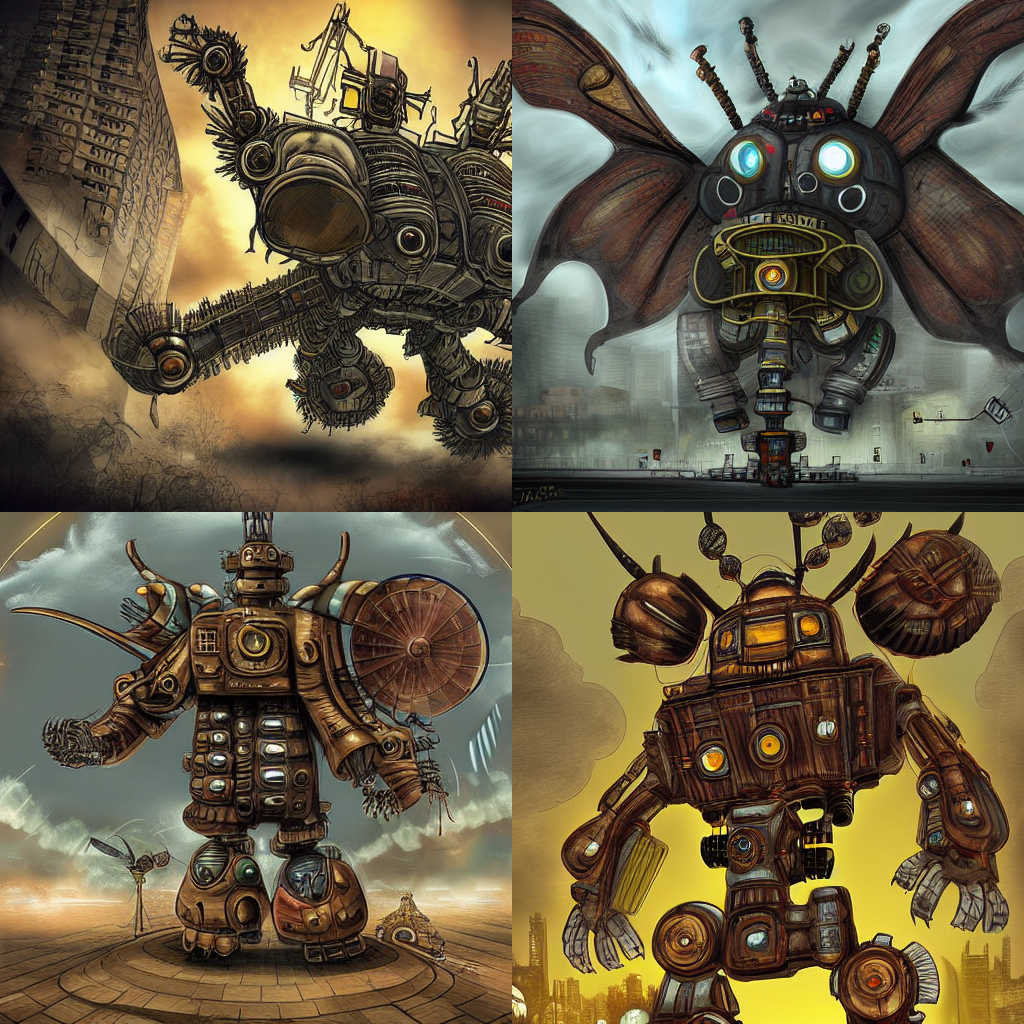

In [ ]:
os.chdir(ArtDir)
file_list = os.listdir()
len(file_list)
#display_image(file_list[0])
#display_image(file_list[1])

In [ ]:
images = []
for i in range(len(file_list)):
  image = cv2.imread(file_list[i])
  images.append(image)
print(f'Read {len(file_list)} images')

In [ ]:
Oplot_images(images)

In [ ]:
grid2 = image_grid(images,30, 10)